<a href="https://colab.research.google.com/github/donib-irakihda/fuse-assignments/blob/main/Assignment_dp_Student_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Dynamic Programming

---

<b><div style="text-align: right">[TOTAL POINTS: 35]</div></b>

In this assignment, you will implement the algorithms that you learned about in the dynamic programming chapter. Using these algorithms, you will find the optimal policy to act in a gridworld. 

Here are the exercises that you will solve today:

* Exercise 1: Action Value Function

    You will use the state values and the environment dynamics to create a function that gives the value of an action.

* Exercise 2, 3, and 4: Policy Evaluation for a Single State

    You will implement policy evaluation in gradual steps in three different exercises: First, you will implement policy evaluation for a single state, and then a single iteration of policy evaluation. Finally, you will implement full policy evaluation until convergence.

* Exercise 5: Policy Improvement

    Here, you will use greedy action selection to improve the policy. 


* Exercise 6: Policy Iteration

    In this exercise, you will combine your policy evaluation and improvement implementations to run policy iteration on the environment.

* Exercise 7: Value Iteration

    In the final exercise, you will implement value iteration using the single sweep version of policy evaluation and policy improvement.

The cell below contains two functions to aid visualization of value functions and policies. We will use them later to visualize our results.

In [1]:
import matplotlib.pyplot as plt

def visualize_value_function(value_function, n, goal_states, roundto=3, min_value=-1, max_value=1):
    fig, ax = plt.subplots()
    fig.set_figheight(n)
    fig.set_figwidth(n)
    mat = [[value_function[j*n+i] for i in range(n)] for j in range(n)]
    ax.matshow(mat, cmap='RdYlGn', vmin=min_value, vmax=max_value)
    ax.axis('off')   

    fig.set_figheight(5)
    fig.set_figwidth(5)
    for i in range(n):
        for j in range(n):
            ax.text(
                i, j, str(round(value_function[j*n+i], roundto)), color='0', 
                fontsize=10, 
                horizontalalignment='center', 
                verticalalignment='center'
            )
def visualize_policy(policy, value_function, n, goal_states, roundto=3, min_value=-1, max_value=1):
    fig, ax = plt.subplots()
    fig.set_figheight(n)
    fig.set_figwidth(n)
    mat = [[value_function[j*n+i] for i in range(n)] for j in range(n)]
    ax.matshow(mat, cmap='RdYlGn', vmin=min_value, vmax=max_value)
    ax.axis('off')   
    
    def get_policy_string(policy, state):
        policies = [policy[state, action] for action in ACTION_SPACE]
        return ['LEFT', 'DOWN', 'RIGHT', 'UP'][max(range(4), key=lambda x: policies[x])]

    fig.set_figheight(5)
    fig.set_figwidth(5)
    for i in range(n):
        for j in range(n):
            ax.text(
                i, j, get_policy_string(policy, i+j*n), color='0', 
                fontsize=10, 
                horizontalalignment='center', 
                verticalalignment='center'
            )

The `Gridworld` class below defines the Markov Decision Process for this task. The two functions in this class that you will find useful are `transition_probability_function` and `reward_function`. Check how they have been implemented.

In [2]:
class GridWorld:

    def __init__(self, n, goal_states, holes=[2,5], goal_reward=+1, hole_reward=-1, living_reward=0):
        self.n = n
        self.states_space = list(range(self.n*self.n))
        self.action_space = [0,1,2,3]
        self.goal_states = goal_states
        self.goal_reward = goal_reward
        self.hole_reward = hole_reward
        self.living_reward = living_reward
        self.holes = holes

    # convenience functions to check if a state lies at an edge
    def is_left_edge(self, state): return (state % self.n)==0
    def is_right_edge(self, state): return ((state+1) % self.n)==0
    def is_top_edge(self, state): return state < self.n
    def is_bottom_edge(self, state): return self.n**2 > state > (self.n**2 - self.n)

    def is_left(self, a, b):
        # checks if state b lies to the left of a
        if self.is_left_edge(a): return False
        return (a-1)==b

    def is_right(self, a, b):
        # checks if state b lies to the right of a
        if self.is_right_edge(a): return False
        return (a+1)==b

    def is_above(self, a, b):
        # checks if state b is above a
        if self.is_top_edge(a): return False
        return (a-self.n)==b

    def is_below(self, a, b):
        # checks if state b is below a
        if self.is_bottom_edge(a): return False
        return (a+self.n)==b

    def get_next_state(self, state, action):
        # determines the state you end up at if you take
        # action `action` at state `state`
        if action == UP:
            if self.is_top_edge(state): return state
            return state - self.n
        if action == LEFT:
            if self.is_left_edge(state): return state
            return state - 1
        if action == DOWN:
            if self.is_bottom_edge(state): return state
            return state + self.n
        if action == RIGHT:
            if self.is_right_edge(state): return state
            return state + 1


    def reward_function(self, initial_state, action):

        # our reward function is dependent on the final state
        final_state = self.get_next_state(initial_state, action)

        # goal states give a reward of -1
        if final_state in self.goal_states: return self.goal_reward

        # states with holes give a reward of -1
        if final_state in self.holes: return self.hole_reward

        # if the final state is neither a goal, nor does it have a hole
        # we return the living reward, which is 0 here
        # a negative living reward results in a policy that favors
        # reaching the goal state in as little transitions as possible
        return self.living_reward


    def transition_probability_function(self, initial_state, action, final_state):

        # if action in initial_state takes us to final_state, return 1
        if final_state == self.get_next_state(initial_state, action):
            return 1
        # otherwise, return 0
        return 0

### Setting up the environment

Our environment is a 4x4 gridworld. It has 16 states, each identified by one of the numbers from 0 to 15. In each state, you can take on of the actions LEFT, DOWN, RIGHT and UP. These actions take you to the corresponding state in the next timestep. For example, if you take the action DOWN in the state 0, the environment takes you to state 4 in the next timestep. This transition is deterministic, which means that taking UP at state 6 *always* takes you to state 2. This simplifies our transition probability function quite a bit, which is why we are making the environment determininistic here. 

<div align="center">
    <figure>
     <img src="https://docs.google.com/uc?export=download&id=1-u3uan1EuvUA1LimsIoSoEgWB7ch6mW3" width="300">
     <figcaption>Our gridworld environment: In state 6, you can take one of the actions for the four directions, and the environment takes you to the corresponding state in the next timestep.</figcaption>
    </figure>
</div>


The rewards are simple. If you somehow end up at the state 3, which we will call the goal state, you get a reward of +1. That is, the actions UP from the state 7, and RIGHT from the state 2 give you a reward of +1. Also, if you read the state 9, you get a reward of -1 because it happens to have a hole in it. 

All other states give you a reward of 0. The reward that an agent gets when nothing else happens is called the living reward. It is simply a reward you get for living upto the next timestep. We can select the living reward strategically to influence the policy. For example, a high living reward results in a policy that takes its time to reach the goal, since it gets a lot of reward in each state anyway. On the other hand, a low or negative living reward forces our policy to reach goals faster in order to minimize the negative rewards it gets on the way. For now, let's just put it at 0.

Think of what the optimal policy for this environment should look like. An optimum policy in this environment would be one that avoids the state 9, and tries to reach state 3.  

In [3]:
# rewards
GOAL_REWARD = +1
HOLE_REWARD = -1
LIVING_REWARD = 0

Now, let's define the action space. There are four actions you can take at any state: LEFT, DOWN, RIGHT and UP. They take you to the corresponding state in the next timestep, except when you are at an edge. If you try taking LEFT at the state 4, which is already the leftmost state in its row, you don't go anywhere, and stay at state 4 in the next timestep too. 

In [4]:
# actions
LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3

# action space
ACTION_SPACE = [LEFT, DOWN, RIGHT, UP]

The state space is made of 16 states like we discussed, and each state is represented by a number between 0 and 15. The image above shows the state number for each state in the grid. 

In [5]:
# size of the gridworld, ours is 4x4
N = 4

# state space -- each state is represented by a unique number
STATE_SPACE = list(range(N*N))

Now, let's create the environment using the GridWorld class. 

In [6]:
GOAL_STATES = [3] # Top right state
HOLES = [9] # State 3 rows from the top and 2 from right

environment = GridWorld(
    n=N,
    goal_states=GOAL_STATES, 
    holes=HOLES, 
    goal_reward=GOAL_REWARD, 
    hole_reward=HOLE_REWARD, 
    living_reward=LIVING_REWARD
)

### Parameterizing the Policy and the State Value

We will parameterize the policy as a dictionary that takes a `(state, action)` tuple as the key, and returns a number between 0 and 1 that tells us the probability that we take action `action` in state `state`. For now, let's make the policy uniform, i.e., we are equally likely to take the four actions in each state. 

In [7]:
POLICY = {(state, action):0.25 for state in STATE_SPACE for action in ACTION_SPACE}

We will also parameterize the state value function as a dictionary. Its key will be state `state`, and it gives a number that is the value of the state. Let's initialize the state value function with zeros for each state. 

In [8]:
STATE_VALUES = {state:0 for state in STATE_SPACE}

## Exercise 1: Action Value Function

---

<b><div style="text-align: right">[TOTAL POINTS: 5]</div></b>

In this exercise, you will use the state value function to compute the action value of an action in a state. Recall that the action value of an action in a state is the sum of the immediate reward you get when you take the action, and the expected discounted value of the next state. 

$$q_\pi (s, a) = R(s,a) + \gamma \sum_{s' \in S} \text{Pr}(s'|s, a) V_\pi(s'a)$$

Implement the above equation in the function `action_value_function` given below. The value function $V_\pi$ is in the dictionary `STATE_VALUES`. The transition probability function $\text{Pr}(s'|s, a)$ is in the `environment.transition_probability_function`. Be sure to check the function's signature out for the correct ordering of arguments. Also, the reward function $R(s,a)$ is in the function `environment.reward_function`. 

In [9]:
### Ex-1-Task-1
GAMMA = 0.9

def action_value_function(state, action):
    ret_action_value = 0
    ### BEGIN SOLUTION
    # your code here
    R = environment.reward_function(state, action)
    second_term = sum([environment.transition_probability_function(state, action, next_state) * STATE_VALUES[next_state] for next_state in STATE_SPACE])
    ret_action_value = R + (GAMMA * second_term)
    # raise NotImplementedError
    ### END SOLUTION
    return ret_action_value

In [10]:
assert action_value_function(2, RIGHT) == 1.0
assert action_value_function(10, LEFT) == -1.0
assert action_value_function(4, UP) == 0

## Exercise 2: Policy evaluation for a Single State

---

<b><div style="text-align: right">[TOTAL POINTS: 5]</div></b>

In this exercise, you will implement policy evaluation for a single state. To do so, you will fill out the function `policy_evaluation_single_state`. Its input is a state, which is a number between 0 and 15, inclusive. You will need to implement the following expression. Use the action value function you built in the previous exercise to calculate $q_\pi(s,a)$. 

$$V'_\pi (s) = \sum _{a \in A} \pi(a|s) q_\pi(s, a)$$

Also, **do not change any values in STATE_VALUES**. You just need to calculate the state value for the next iteration for a particular state. We will update the state value function in the next exercise.

In [11]:
### Ex-2-Task-1
def policy_evaluation_single_state(state):
    new_state_value = 0
    ### BEGIN SOLUTION
    # your code here
    new_state_value = GAMMA * sum([POLICY[(state, action)] * action_value_function(state, action) for action in ACTION_SPACE])
    # raise NotImplementedError
    ### END SOLUTION
    return new_state_value

In [12]:
assert policy_evaluation_single_state(2) == 0.225
assert policy_evaluation_single_state(10) == -0.225
assert policy_evaluation_single_state(6) == 0

## Exercise 3: Single Sweep of Policy Evaluation

---

<b><div style="text-align: right">[TOTAL POINTS: 5]</div></b>

In this exercise, you will implement a single sweep of policy evaluation for all states. To do so, you will fill out the function `policy_evaluation_single_sweep`. Roughly, here is the pseudocode you will need to follow. 

```
for each state in STATE_SPACE
    new_state_value(state) = policy_evaluation_single_state(state)    
    
for each state in STATE_SPACE
    delta(state) = |state_value(state) - new_state_value(state)|
    state_value(state) ← new_state_value(state)

return max(delta)
```

Here are the implementation details for this function:

1. Remember that the value of a terminal state should be 0. In this environment, there is a single terminal state, that is state 3. Make sure its value is 0. You do not need to updates its state value because its already 0 in our parameterization. 

2. Also, you will need to find out the largest absolute change in the value function for all states, and return it. In the code cell below, we have named the variable `delta`. 

3. Make sure to not change the value function of any state during the evaluation stage. Calculate the value function for each state and store it somewhere, and when the calculations are done, update all the values at once. The pseudocode above shows you roughly how you can do it. If you update in-place, **you will fail this exercise and others that depend on this function**.

In [13]:
### Ex-3-Task-1
def policy_evaluation_single_sweep():
    delta = 0
    ### BEGIN SOLUTION
    # your code here
    new_state_value = list(range(len(STATE_SPACE)))
    delta = list(range(len(STATE_SPACE)))
    state_value = [0 for _ in range(len(STATE_SPACE))]
    for state in STATE_SPACE:
        new_state_value[state] = policy_evaluation_single_state(state)
        new_state_value[3] = 0
        delta[state] = abs(STATE_VALUES[state] - new_state_value[state])
        state_value[state] = new_state_value[state]
    for state in STATE_SPACE:
        STATE_VALUES[state] = state_value[state]
    delta = max(delta)
    # raise NotImplementedError
    ### END SOLUTION
    return delta

In [14]:
delta = policy_evaluation_single_sweep()


Here is the state value function after one iteration. Notice how the cells around the hole have a negative value, and the cells around the goal state have a value higher than the default 0. In a single iteration, the algorithm can only update values using the value of the states you can reach in the next timestep, so only states with some immediate reward have changed. 

If you run this cell more than once, you can see the how the state value function changes with more and more iterations of polict evaluation. Be sure to check it out!

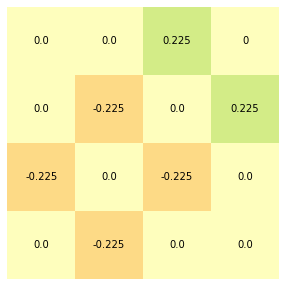

In [15]:
visualize_value_function(STATE_VALUES, 4, [3])
delta = policy_evaluation_single_sweep()

## Exercise 4: Policy Evaluation until Convergence

---

<b><div style="text-align: right">[TOTAL POINTS: 5]</div></b>

In this exercise, you will implement policy evaluation until convergence. To do so, you will fill out the function `policy_evaluation`. You will use the function `policy_evaluation_single_sweep` that you built above to do this.  

When the change in the value function is smaller than `MAX_DELTA`, you can consider that the value function has converged, and stop the iteration. 

In [16]:
### Ex-4-Task-1

STATE_VALUES = {state:0 for state in STATE_SPACE}
MAX_DELTA = 0.001

def policy_evaluation():
    ### BEGIN SOLUTION
    # your code here
    while True:
      delta = policy_evaluation_single_sweep()
      if delta < MAX_DELTA:
        break
    # raise NotImplementedError
    ### END SOLUTION

In [17]:
policy_evaluation()

Here is the value function after convergence:

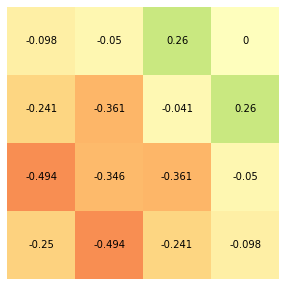

In [18]:
visualize_value_function(STATE_VALUES, 4, [3])

## Exercise 5: Policy Improvement

---

<b><div style="text-align: right">[TOTAL POINTS: 5]</div></b>

In this exercise, you will implement policy improvement. To do so, you will fill out the function `policy_improvement`. The expression for greedily improving the policy is given below. Use the expression to greedily improve the policy for each state in the state space. Remember that the policy is implemented as the `POLICY` dictionary. Therefore, you will need to mutate it. 

$$
    \pi(s,a)= 
\begin{cases}
    1, & \text{if } q_\pi(s,a) = max_a\ q_\pi(s,a)\\
    0,              & \text{otherwise}
\end{cases}
$$


In this gridworld, a single state can have more than 1 optimum action. Make sure that all the optimal actions in the same state do not have a probability of 1 in the `POLICY` dictionary. To do this, you can do one of the following:

1. Set one of the optimal actions to have a probability of 1, and set all the other actions to have probabilities of 0. 

2. Set all the optimal actions to have the same probability. For example, in state 6, both UP and RIGHT can be equally optimal if the states 2 and 7 both point to the goal state 3. You can then set `POLICY` in this way:

```
POLICY(state=6, action=UP)    = 0.5
POLICY(state=6, action=RIGHT) = 0.5
POLICY(state=7, action=LEFT)  = 0
POLICY(state=7, action=DOWN)  = 0
```

In [19]:
### Ex-5-Task-1
def policy_improvement():
    ### BEGIN SOLUTION
    # your code here
    for pair in list(POLICY.keys()):
        action_value = [action_value_function(pair[0], action) for action in ACTION_SPACE]
        improved_policy = [1 if o==max(action_value) else 0 for o in action_value]
        for i, j in enumerate(improved_policy):
            POLICY[pair[0], i] = j
    # raise NotImplementedError
    ### END SOLUTION

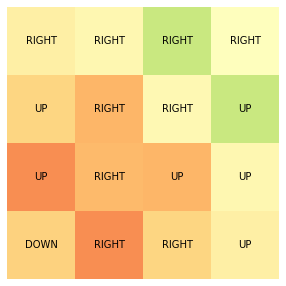

In [20]:
policy_improvement()
visualize_policy(POLICY, STATE_VALUES, 4, [3])

## Exercise 6: Policy Iteration

---

<b><div style="text-align: right">[TOTAL POINTS: 5]</div></b>

In this exercise, you will implement policy iteration. To do so, you will fill out the function `policy_iteration`. 

In the cell immediately below this, you will find the function `is_policy_stable`. It takes in two policies, and returns `True` if the two policies are the same. 

In the `policy_iteration` function, the `is_policy_stable` function has been used to find out if policy iteration has converged. You will need to fill out the actual steps of the Policy Iteration algorithm. Make sure to use the functions you have built in the exercises above, the solution to this exercise is just a couple of function calls, that is it!

In [21]:
def is_policy_stable(old_policy, new_policy):
    for state in STATE_SPACE:
        for action in ACTION_SPACE:
            if old_policy[state, action] != new_policy[state, action]:
                return False
    return True

In [22]:
### Ex-6-Task-1
def policy_iteration():
    policy_stable = False
    while not policy_stable:
        old_policy = dict(POLICY)
        ### BEGIN SOLUTION
        # your code here
        policy_evaluation()
        policy_improvement()
        # raise NotImplementedError
        ### END SOLUTION
        new_policy = dict(POLICY)
        policy_stable = is_policy_stable(old_policy, new_policy)

In [23]:
POLICY = {(state, action):0.25 for state in STATE_SPACE for action in ACTION_SPACE}
STATE_VALUES = {state:0 for state in STATE_SPACE}
policy_iteration()


KeyboardInterrupt: ignored

Here is the optimal policy calculated by your policy iteration implementation. If your implementation is correct, the policy should avoid the hole, and the value of all the states should be positive (green here). 

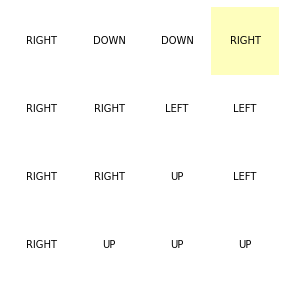

In [24]:
visualize_policy(POLICY, STATE_VALUES, 4, [3])

## Exercise 7: Value Iteration

---

<b><div style="text-align: right">[TOTAL POINTS: 5]</div></b>

In this exercise, you will implement value iteration. To do so, you will fill out the function `value_iteration`. 

In value iteration, recall that you need to do a single sweep of policy evaluation, and then improve the policy immediately. Convergence is, again, determined by the `MAX_DELTA` parameter, so run the iterations until the difference between consecutive value functions is smaller than `MAX_DELTA`. 

In [25]:
### Ex-7-Task-1

def value_iteration():
    MAX_DELTA = 0.01
    ### BEGIN SOLUTION
    # your code here
    while True:
      delta = policy_evaluation_single_sweep()
      policy_improvement()

      if delta < MAX_DELTA:
        break
    # raise NotImplementedError
    ### END SOLUTION

In [26]:
POLICY = {(state, action):0.25 for state in STATE_SPACE for action in ACTION_SPACE}
STATE_VALUES = {state:0 for state in STATE_SPACE}

value_iteration()


KeyboardInterrupt: ignored

Just to be sure, here is the optimal policy and its value function calculated by the value iteration algorithm you implemented. Make sure the results match that of policy iteration.

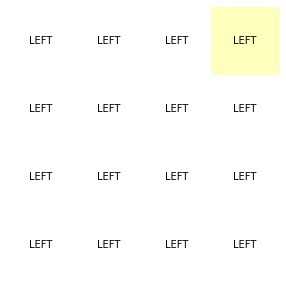

In [27]:
visualize_policy(POLICY, STATE_VALUES, 4, [3])

## Conclusion

In this assignment, you have implemented different algorithms that use dynamic programming to find the optimal policy and value function for an environment. We hope that you have truly understood the algorithms in this chapter now. Getting an intuitive feel for what they are doing will help you understand the concepts in the next few chapters. Congratulations on completing the assignment!